In [2]:
import sys

sys.path.append("D:/Anaconda/envs/micrograd/Lib/site-packages")

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch
import random

In [4]:
from typing import Any


class Value:
    def __init__(self,data, _children=(),_op="",label=''):
        self.data= data
        self.grad =0.0
        self._backward= lambda: None
        self._prev = set(_children)
        self._op=_op
        self.label= label
    def __repr__(self) :
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other,label='d')
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad           
        out._backward=_backward
        return out
    
    def __radd__(self,other):
        return self + other

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other,label='d')
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data *out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) *out.grad
        out._backward= _backward
        return out

    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):

        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')

        def _backward():
            self.grad += (1- t**2) *out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited :
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward() 
    
a= Value(2.0,label='a')
b= Value(4.0,label='b')
c= Value(10.0,label='c')
e = a*b; e.label='e'
d=e+c; d.label = 'd'
f= Value(-2.0,label='f')
L =d*f ; L.label='L'
a-b



Value(data=-2.0)

In [5]:
def trace(root):

    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes ,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'}) #LR =Left to Right

    nodes,edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        # for any value in the graph, crete a rectangular {'record'} node for it
        dot.node( name =uid, label ='{ %s | data %.4f |grad %.4f}' % (n.label,n.data,n.grad), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op,label= n._op)
            # and connect this node to it
            dot.edge(uid+ n._op,uid)

    for n1 , n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot


In [6]:
class Neuron :
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1),label=f'w') for _ in range(nin)]
        self.b =Value(random.uniform(-1,1),label=f'b')
    
    def __call__(self,x):
        #w * x + b  
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b  ) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons= [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        params= []
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps)
        return params
        #with list comprehension : return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x  
    
    def parameters(self):
        params=[]
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params



In [11]:
n= MLP(3,[4,4,1])
xs =[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0] #desired targets


In [8]:

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs ]
    loss = sum([(yout- ygt)**2 for ygt ,yout in zip(ys,ypred)])
    #backprop
    for p in n.parameters():
        p.grad +=  0.0
    loss.backward()
    #update
    for p in n.parameters():
        p.data +=  -0.01 * p.grad  
    
    print(f'****Step:{k+1},Current Loss:{loss.data}****')



****Step:1,Current Loss:7.727061936400013****
****Step:2,Current Loss:7.079261764505664****
****Step:3,Current Loss:5.924217613396703****
****Step:4,Current Loss:4.7713091730030435****
****Step:5,Current Loss:3.8009288352407955****
****Step:6,Current Loss:2.9158506467632925****
****Step:7,Current Loss:2.453234098960275****
****Step:8,Current Loss:2.672042800134637****
****Step:9,Current Loss:2.9461251512542215****
****Step:10,Current Loss:2.5351285104290158****
****Step:11,Current Loss:1.4022717825694284****
****Step:12,Current Loss:0.5754955493286182****
****Step:13,Current Loss:0.611184895142423****
****Step:14,Current Loss:0.6612386436786586****
****Step:15,Current Loss:0.15798171513214873****
****Step:16,Current Loss:0.015191652627551224****
****Step:17,Current Loss:0.0016931991974212844****
****Step:18,Current Loss:0.00028423475421773397****
****Step:19,Current Loss:6.248845119860066e-05****
****Step:20,Current Loss:1.5910535787443836e-05****


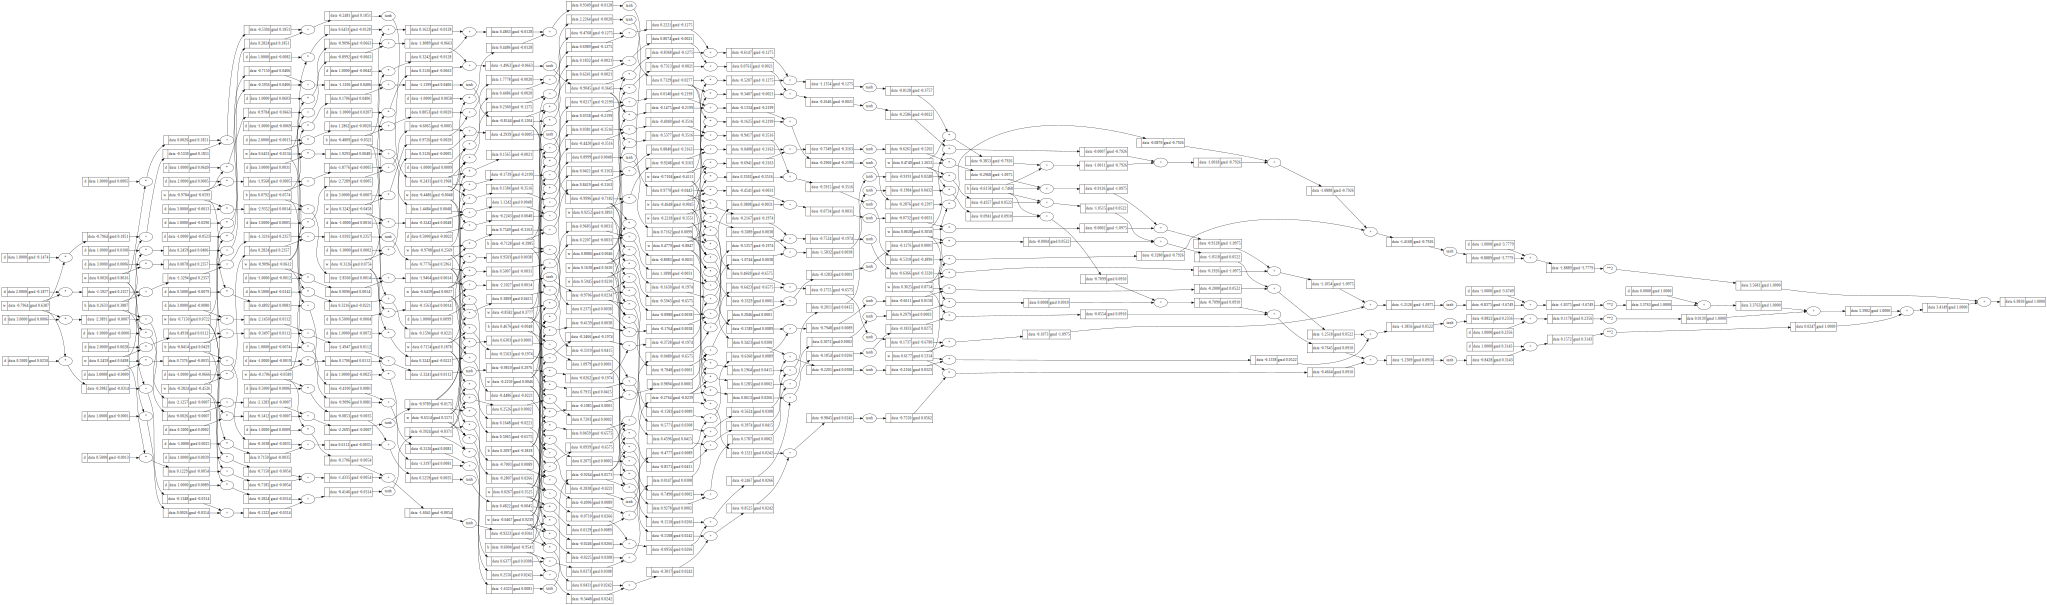

In [65]:
draw_dot(loss)

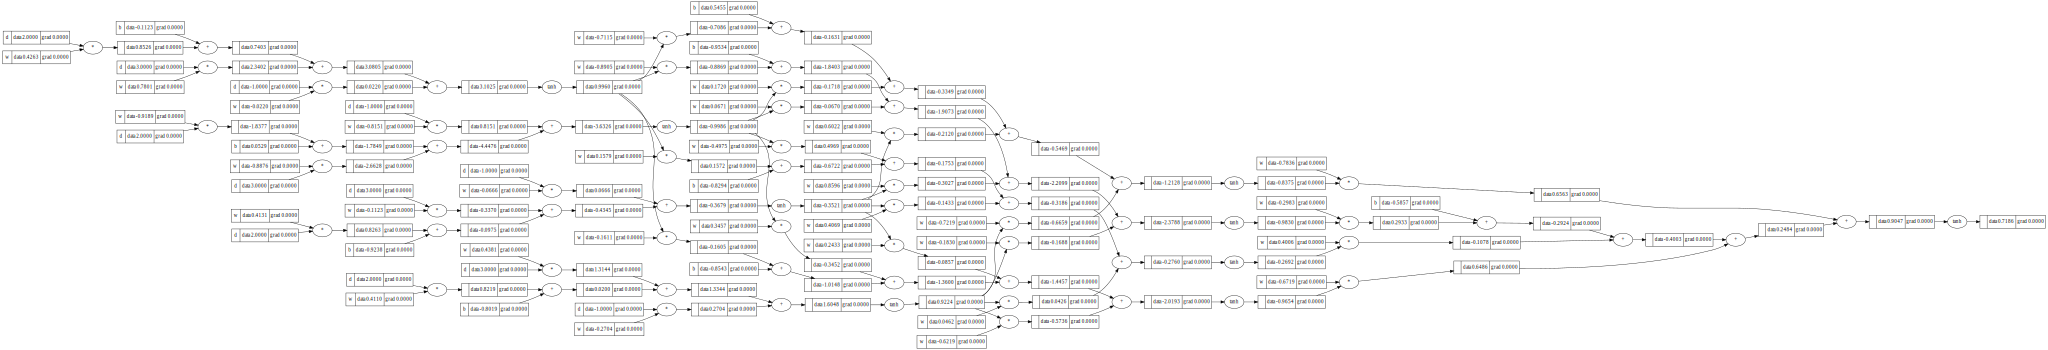

In [14]:
#Representation of forward pass
x= [2.0,3.0,-1.0]
m = MLP(3,[4,4,1])

draw_dot(m(x))